<a href="https://colab.research.google.com/github/nelsonalbertohj/Magno-Parvo-CNN/blob/main/Data_analysis_and_results.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

### Data Analysis and Results

In [4]:
!pip install tensorflow_addons

In [5]:
import tensorflow as tf
import tensorflow_datasets as tfds
import os
import numpy as np
import pathlib
import matplotlib.pyplot as plt
import pandas as pd

import keras
import time
from keras.models import Sequential
from keras.layers import Dense, Conv2D, MaxPool2D , Flatten, Average
from keras.preprocessing.image import ImageDataGenerator
import tensorflow_addons as tfa
from sklearn.metrics import classification_report, ConfusionMatrixDisplay, confusion_matrix, matthews_corrcoef
import seaborn as sn
import matplotlib.colors as colors
from scipy.stats import binom

plt.rcParams['font.size'] = '12'
print("Tensorflow version: ",tf.__version__)
%matplotlib inline

Tensorflow version:  2.8.0


In [6]:
from google.colab import drive
drive.mount('/content/drive', force_remount=True)

ModuleNotFoundError: No module named 'google.colab'

### Loading Testing Sets and Models

In [ ]:
root = "C:/Users/nelso/My Drive (nelsonh@mit.edu)/Vision Dataset"
N_CLASSES = 10
loc = root + f"/Imagenet-{N_CLASSES}-1500-splits/test"
data_dir = pathlib.Path(loc)

occlude_loc = root + f"/Imagenet-{N_CLASSES}-1500-splits/test_occluded"
occlude_dir = pathlib.Path(occlude_loc)

batch_size = 32
img_height = 224
img_width = 224

#Testing set
test_ds = tf.keras.utils.image_dataset_from_directory(
  data_dir,
  seed=123,
  label_mode = 'categorical',
  image_size=(img_height, img_width),
  batch_size=batch_size)

test_occlude_ds = tf.keras.utils.image_dataset_from_directory(
  occlude_dir,
  seed=123,
  label_mode = 'categorical',
  image_size=(img_height, img_width),
  batch_size=batch_size)

In [ ]:
def img_transforms(data,label): #The vanilla testing set
    normalize_img = tf.keras.layers.Rescaling(1./255)
    color_norm = normalize_img(data)
    gray_img = tf.image.rgb_to_grayscale(data)
    gray_norm_img = normalize_img(gray_img)
    gray_norm_img = tfa.image.gaussian_filter2d(gray_norm_img,filter_shape=(10,10),sigma=5.0)
    concat_img = tf.concat([color_norm, gray_norm_img],axis=-1)
    return concat_img,label

def blurr_img_transforms(data,label): #The blurred testing set
    data = tfa.image.gaussian_filter2d(data,filter_shape=(10,10),sigma=5.0)
    normalize_img = tf.keras.layers.Rescaling(1./255)
    color_norm = normalize_img(data)
    gray_img = tf.image.rgb_to_grayscale(data)
    gray_norm_img = normalize_img(gray_img)
    gray_norm_img = tfa.image.gaussian_filter2d(gray_norm_img,filter_shape=(10,10),sigma=5.0)
    concat_img = tf.concat([color_norm, gray_norm_img],axis=-1)
    return concat_img,label

AUTOTUNE = tf.data.AUTOTUNE
test_ds_vanilla = test_ds.map(img_transforms)
test_ds_blurred = test_ds.map(blurr_img_transforms)
test_ds_occluded = test_occlude_ds.map(img_transforms)

CASHE_Test_vanilla = root + f"/Imagenet-{N_CLASSES}-1500-splits/CASHE_Test_{N_CLASSES}_1500"
test_ds_vanilla = test_ds_vanilla.cache(CASHE_Test_vanilla).prefetch(buffer_size=AUTOTUNE)

CASHE_Test_blurred = root + f"/Imagenet-{N_CLASSES}-1500-splits/CASHE_Test_Dist_Blur_{N_CLASSES}_1500"
test_ds_blurred = test_ds_blurred.cache(CASHE_Test_blurred).prefetch(buffer_size=AUTOTUNE)

CASHE_Test_occlude = root + f"/Imagenet-{N_CLASSES}-1500-splits/CASHE_Test_Dist_Occlude_{N_CLASSES}_1500"
test_ds_occluded = test_ds_occluded.cache(CASHE_Test_occlude).prefetch(buffer_size=AUTOTUNE)

In [ ]:
class_names = test_ds.class_names
gray_imgs = []
plt.figure(figsize=(10, 10))
for images, labels in test_ds_vanilla.take(1):
    for i in range(9):
        ax = plt.subplot(3, 3, i + 1)
        current_img = images[i]
        if i == 0:
            print("Origianl: ", current_img.numpy()[:,:,:-1].dtype)
        plt.imshow(current_img.numpy()[:,:,:-1])
        gray_imgs.append((current_img,np.argmax(labels[i])))
        plt.title(class_names[np.argmax(labels[i])])
        plt.axis("off")
plt.figure(figsize=(10, 10))
for images, labels in test_ds_blurred.take(1):
    for i in range(9):
        ax = plt.subplot(3, 3, i + 1)
        current_img = images[i]
        if i == 0:
            print("Original: ", current_img.numpy()[:,:,-1].dtype)
        plt.imshow(current_img.numpy()[:,:,-1],cmap="gray")
        gray_imgs.append((current_img,np.argmax(labels[i])))
        plt.title(class_names[np.argmax(labels[i])])
        plt.axis("off")
plt.figure(figsize=(10, 10))
for images, labels in test_ds_occluded.take(1):
    for i in range(9):
        ax = plt.subplot(3, 3, i + 1)
        current_img = images[i]
        if i == 0:
            print("New format: ", current_img.numpy()[:,:,:-1].dtype)
        plt.imshow(current_img.numpy()[:,:,:-1])
        gray_imgs.append((current_img,np.argmax(labels[i])))
        plt.title(class_names[np.argmax(labels[i])])
        plt.axis("off")

In [7]:
# Used to create CASHE in local disk by loading all images
idx = 0
start_time = time.time()
for t in test_ds_vanilla:
  print("time to get object: ", time.time()-start_time)
  idx += 1
  start_time = time.time()

time to get object:  0.18872523307800293
time to get object:  0.04936528205871582
time to get object:  0.04557633399963379
time to get object:  0.04463315010070801
time to get object:  0.04295802116394043
time to get object:  0.0440673828125
time to get object:  0.045114755630493164
time to get object:  0.04329633712768555
time to get object:  0.043703317642211914
time to get object:  0.04302477836608887
time to get object:  0.04301023483276367
time to get object:  0.04145526885986328
time to get object:  0.04411053657531738
time to get object:  0.044149160385131836
time to get object:  0.04309201240539551
time to get object:  0.04275202751159668
time to get object:  0.04499959945678711
time to get object:  0.042360544204711914
time to get object:  0.044060468673706055
time to get object:  0.042838096618652344
time to get object:  0.04471135139465332
time to get object:  0.044538259506225586
time to get object:  0.04210638999938965
time to get object:  0.04454159736633301
time to get o

In [8]:
dual_stream_model = tf.keras.models.load_model(root + f"/Models/Early_Testing_Models/FullRes_with_CNN_1000_Samples_{N_CLASSES}Classes")
single_model = tf.keras.models.load_model(root + f"/Models/Early_Testing_Models/Dualstream_with_CNN_1000_Samples_{N_CLASSES}Classes")

class_names = test_ds.class_names
class_names = [c if c != "African elephant" else "elephant" for c in class_names]

### Testing the Vanilla Testing Set

In [9]:
fig_loc = r"C:\Users\nelso\Google Drive\School\MIT Spring2022\9.60\Vision Project\Analysis Figures"

dual_test_loss, dual_test_accuracy = dual_stream_model.evaluate(test_ds_vanilla)

single_test_loss, signle_test_accuracy = single_model.evaluate(test_ds_vanilla)

41/41 [==============================] - 3s 46ms/step - loss: 1.1965 - accuracy: 0.7826


In [10]:
#Load Train and Test
dual_pred_outputs = dual_stream_model.predict(test_ds_vanilla)
dual_pred_outputs = np.argmax(dual_pred_outputs,axis=1)

single_pred_outputs = single_model.predict(test_ds_vanilla)
single_pred_outputs = np.argmax(single_pred_outputs,axis=1)

true_outputs = np.concatenate([labels for _,labels in test_ds_vanilla])
true_outputs = np.argmax(true_outputs,axis=1)

In [11]:
print(classification_report(true_outputs,dual_pred_outputs))
print(matthews_corrcoef(true_outputs, dual_pred_outputs))

              precision    recall  f1-score   support

           0       0.92      0.74      0.82       140
           1       0.97      0.91      0.93       127
           2       0.63      0.79      0.70       135
           3       0.71      0.82      0.76       125
           4       0.75      0.70      0.73       125
           5       0.67      0.78      0.72       128
           6       0.77      0.84      0.80       139
           7       0.78      0.57      0.66       127
           8       0.79      0.94      0.86       127
           9       0.82      0.60      0.69       124

    accuracy                           0.77      1297
   macro avg       0.78      0.77      0.77      1297
weighted avg       0.78      0.77      0.77      1297

0.7460387968527745


Text(20.775000000000063, 0.5, 'True Label')

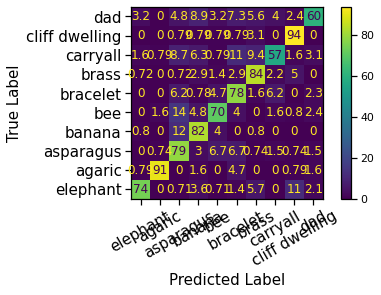

In [12]:
#Generate Confusion Matrix for Dual-stream model
import seaborn as sns
sns.set_context('notebook')

A = confusion_matrix(true_outputs,dual_pred_outputs)

cm_dual_vanilla = confusion_matrix(true_outputs,dual_pred_outputs,normalize='true') * 100

disp_cm = ConfusionMatrixDisplay(cm_dual_vanilla,
                                 display_labels=class_names)

disp_cm.plot()

disp_cm.ax_.set_xticks([i for i in range(10)],labels=class_names, rotation = 30)
disp_cm.ax_.invert_yaxis()
plt.tight_layout()
disp_cm.ax_.tick_params(labelsize=15)
disp_cm.ax_.set_xlabel("Predicted Label",fontsize=15)
disp_cm.ax_.set_ylabel("True Label",fontsize=15)

In [13]:
print(classification_report(true_outputs,single_pred_outputs))
print(matthews_corrcoef(true_outputs, single_pred_outputs))

              precision    recall  f1-score   support

           0       0.85      0.79      0.82       140
           1       0.92      0.87      0.89       127
           2       0.75      0.83      0.79       135
           3       0.66      0.86      0.75       125
           4       0.70      0.80      0.75       125
           5       0.75      0.70      0.73       128
           6       0.85      0.85      0.85       139
           7       0.82      0.57      0.67       127
           8       0.88      0.83      0.85       127
           9       0.70      0.73      0.71       124

    accuracy                           0.78      1297
   macro avg       0.79      0.78      0.78      1297
weighted avg       0.79      0.78      0.78      1297

0.759303661432496


Text(20.775000000000063, 0.5, 'True Label')

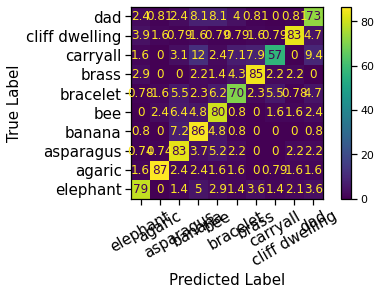

In [14]:
#Generate Confusion Matrix for Single-stream ResNet
cm_single_vanilla = confusion_matrix(true_outputs,single_pred_outputs, normalize='true') * 100

disp_cm = ConfusionMatrixDisplay(cm_single_vanilla,display_labels=class_names)

disp_cm.plot()

disp_cm.ax_.set_xticks([i for i in range(10)],labels=class_names, rotation = 30)
disp_cm.ax_.invert_yaxis()
plt.tight_layout()
disp_cm.ax_.tick_params(labelsize=15)
disp_cm.ax_.set_xlabel("Predicted Label",fontsize=15)
disp_cm.ax_.set_ylabel("True Label",fontsize=15)

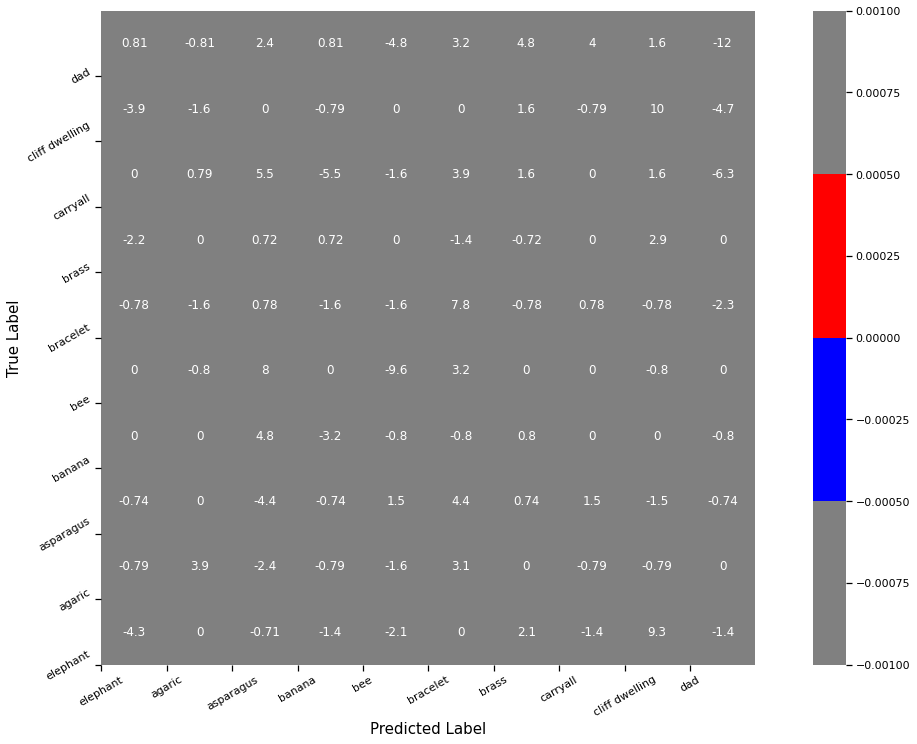

In [15]:
# Confusion Difference Matrix (Dual minus Single)

cm_diff_vanilla = cm_dual_vanilla - cm_single_vanilla

B = confusion_matrix(true_outputs,single_pred_outputs)
n_trials = np.sum(B, axis=1)
p = confusion_matrix(true_outputs,single_pred_outputs, normalize='true')
m = np.copy(B)
C = np.zeros(shape=(10,10))
for row in range(10):
    n = n_trials[row]
    for col in range(10):
        dist = binom(n,p[row, col])
        if cm_diff_vanilla[row,col] >= 0:
            sign = 1
        else:
            sign = -1
        C[row,col] = dist.pmf(B[row,col]) * sign

cmap = colors.ListedColormap(["gray", "blue", "red", "gray"])
fig, ax = plt.subplots()
fig.set_size_inches(16.5, 10.5)
ax= sn.heatmap(C, ax=ax, center=0, vmax=1e-3, vmin=-1e-3, square=True, annot=cm_diff_vanilla, cmap=cmap)

ax.set_xticks([i for i in range(10)],labels=class_names, rotation = 30)
ax.set_yticks([i for i in range(10)],labels=class_names, rotation = 30)
ax.set_xlabel("Predicted Label",fontsize=15)
ax.set_ylabel("True Label",fontsize=15)
ax.invert_yaxis()
plt.tight_layout()

### Testing the Blurred condition

In [16]:
dual_test_loss, dual_test_accuracy = dual_stream_model.evaluate(test_ds_blurred)

single_test_loss, signle_test_accuracy = single_model.evaluate(test_ds_blurred)

41/41 [==============================] - 1s 33ms/step - loss: 2.5778 - accuracy: 0.5459


In [17]:
#Load Train and Test
dual_pred_outputs = dual_stream_model.predict(test_ds_blurred)
dual_pred_outputs = np.argmax(dual_pred_outputs,axis=1)

single_pred_outputs = single_model.predict(test_ds_blurred)
single_pred_outputs = np.argmax(single_pred_outputs,axis=1)

true_outputs = np.concatenate([labels for _,labels in test_ds_blurred])
true_outputs = np.argmax(true_outputs,axis=1)

In [18]:
print(classification_report(true_outputs,dual_pred_outputs))
print(matthews_corrcoef(true_outputs, dual_pred_outputs))

              precision    recall  f1-score   support

           0       0.87      0.44      0.58       140
           1       0.97      0.77      0.86       127
           2       0.39      0.88      0.54       135
           3       0.66      0.60      0.63       125
           4       0.63      0.70      0.66       125
           5       0.51      0.70      0.59       128
           6       0.88      0.68      0.76       139
           7       0.85      0.31      0.46       127
           8       0.79      0.72      0.75       127
           9       0.59      0.60      0.60       124

    accuracy                           0.64      1297
   macro avg       0.71      0.64      0.64      1297
weighted avg       0.72      0.64      0.64      1297

0.6077948055109794


Text(20.775000000000063, 0.5, 'True Label')

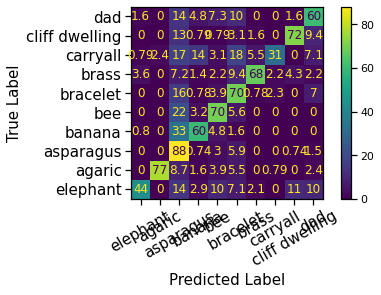

In [19]:
#Generate Confusion Matrix for Dual-stream model

cm_dual_blur = confusion_matrix(true_outputs,dual_pred_outputs,normalize='true') * 100

disp_cm = ConfusionMatrixDisplay(cm_dual_blur,display_labels=class_names)

disp_cm.plot()

disp_cm.ax_.set_xticks([i for i in range(10)],labels=class_names, rotation = 30)
disp_cm.ax_.invert_yaxis()
plt.tight_layout()
disp_cm.ax_.tick_params(labelsize=15)
disp_cm.ax_.set_xlabel("Predicted Label",fontsize=15)
disp_cm.ax_.set_ylabel("True Label",fontsize=15)

In [20]:
print(classification_report(true_outputs,single_pred_outputs))
print(matthews_corrcoef(true_outputs, single_pred_outputs))

              precision    recall  f1-score   support

           0       0.71      0.54      0.61       140
           1       0.96      0.72      0.83       127
           2       0.38      0.85      0.53       135
           3       0.43      0.37      0.40       125
           4       0.47      0.70      0.56       125
           5       0.50      0.52      0.51       128
           6       0.87      0.43      0.58       139
           7       0.65      0.38      0.48       127
           8       0.58      0.33      0.42       127
           9       0.49      0.62      0.55       124

    accuracy                           0.55      1297
   macro avg       0.60      0.55      0.55      1297
weighted avg       0.61      0.55      0.55      1297

0.502932357284799


In [21]:
#Generate Confusion Matrix for Single-stream ResNet

cm_single_blur = confusion_matrix(true_outputs,single_pred_outputs,normalize='true') * 100

disp_cm = ConfusionMatrixDisplay(cm_single_blur,display_labels=class_names)
disp_cm.plot(ax=ax)
disp_cm.ax_.invert_yaxis()
plt.tight_layout()
disp_cm.ax_.tick_params(labelsize=15)
disp_cm.ax_.set_xlabel("Predicted Label",fontsize=15)
disp_cm.ax_.set_ylabel("True Label",fontsize=15)

Text(22.200000000000045, 0.5, 'True Label')

<Figure size 432x288 with 0 Axes>

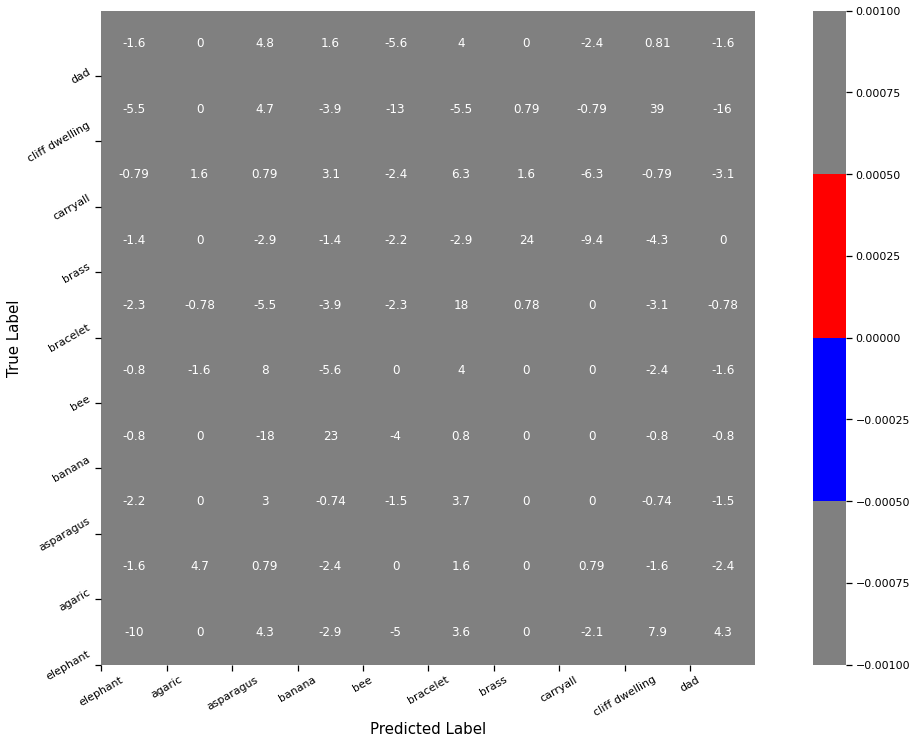

In [22]:
# Confusion Difference Matrix (Dual minus Single)

cm_diff_blur = cm_dual_blur - cm_single_blur

B = confusion_matrix(true_outputs,single_pred_outputs)
n_trials = np.sum(B, axis=1)
p = confusion_matrix(true_outputs,single_pred_outputs, normalize='true')
m = np.copy(B)
C = np.zeros(shape=(10,10))
for row in range(10):
    n = n_trials[row]
    for col in range(10):
        dist = binom(n,p[row, col])
        if cm_diff_blur[row,col] >= 0:
            sign = 1
        else:
            sign = -1
        C[row,col] = dist.pmf(B[row,col]) * sign

cmap = colors.ListedColormap(["gray", "blue", "red", "gray"])
fig, ax = plt.subplots()
fig.set_size_inches(16.5, 10.5)
ax= sn.heatmap(C, ax=ax, center=0, vmax=1e-3, vmin=-1e-3, square=True, annot=cm_diff_blur, cmap=cmap)
ax.set_xticks([i for i in range(10)],labels=class_names, rotation = 30)
ax.set_yticks([i for i in range(10)],labels=class_names, rotation = 30)
ax.set_xlabel("Predicted Label",fontsize=15)
ax.set_ylabel("True Label",fontsize=15)
ax.invert_yaxis()
plt.tight_layout()

### Testing the Occluded condition:

In [23]:
dual_test_loss, dual_test_accuracy = dual_stream_model.evaluate(test_ds_occluded)
single_test_loss, signle_test_accuracy = single_model.evaluate(test_ds_occluded)

41/41 [==============================] - 2s 46ms/step - loss: 4.4350 - accuracy: 0.2407


In [24]:
#Load Train and Test
dual_pred_outputs = dual_stream_model.predict(test_ds_occluded)
dual_pred_outputs = np.argmax(dual_pred_outputs,axis=1)

single_pred_outputs = single_model.predict(test_ds_occluded)
single_pred_outputs = np.argmax(single_pred_outputs,axis=1)

true_outputs = np.concatenate([labels for _,labels in test_ds_occluded])
true_outputs = np.argmax(true_outputs,axis=1)

In [25]:
print(classification_report(true_outputs,dual_pred_outputs))
print(matthews_corrcoef(true_outputs, dual_pred_outputs))

              precision    recall  f1-score   support

           0       0.00      0.00      0.00       140
           1       0.76      0.32      0.45       127
           2       0.25      0.15      0.19       135
           3       0.87      0.10      0.19       125
           4       0.10      0.49      0.16       125
           5       0.17      0.57      0.26       128
           6       0.04      0.02      0.03       139
           7       0.00      0.00      0.00       127
           8       0.00      0.00      0.00       127
           9       0.00      0.00      0.00       123

    accuracy                           0.16      1296
   macro avg       0.22      0.17      0.13      1296
weighted avg       0.21      0.16      0.13      1296

0.08542462573477518


C:\Users\nelso\anaconda3\envs\tf-gpu\lib\site-packages\sklearn\metrics\_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\nelso\anaconda3\envs\tf-gpu\lib\site-packages\sklearn\metrics\_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\nelso\anaconda3\envs\tf-gpu\lib\site-packages\sklearn\metrics\_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Text(20.775000000000063, 0.5, 'True Label')

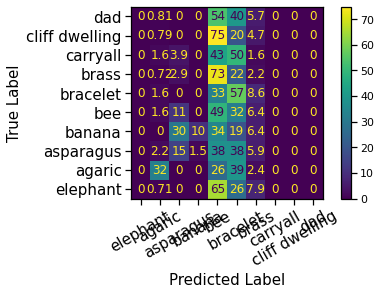

In [26]:
#Generate Confusion Matrix for Dual-stream model
A = confusion_matrix(true_outputs,dual_pred_outputs)
cm_dual_vanilla = confusion_matrix(true_outputs,dual_pred_outputs,normalize='true') * 100

disp_cm = ConfusionMatrixDisplay(cm_dual_vanilla,display_labels=class_names)

disp_cm.plot()
disp_cm.ax_.set_xticks([i for i in range(10)],labels=class_names, rotation = 30)
disp_cm.ax_.invert_yaxis()
plt.tight_layout()
disp_cm.ax_.tick_params(labelsize=15)
disp_cm.ax_.set_xlabel("Predicted Label",fontsize=15)
disp_cm.ax_.set_ylabel("True Label",fontsize=15)

In [27]:
print(classification_report(true_outputs,single_pred_outputs))
print(matthews_corrcoef(true_outputs, single_pred_outputs))

              precision    recall  f1-score   support

           0       0.20      0.01      0.01       140
           1       0.42      0.54      0.47       127
           2       0.39      0.35      0.37       135
           3       0.60      0.24      0.34       125
           4       0.15      0.45      0.22       125
           5       0.14      0.55      0.23       128
           6       0.70      0.19      0.30       139
           7       0.25      0.10      0.15       127
           8       0.00      0.00      0.00       127
           9       0.00      0.00      0.00       123

    accuracy                           0.24      1296
   macro avg       0.29      0.24      0.21      1296
weighted avg       0.29      0.24      0.21      1296

0.17383399368284638


C:\Users\nelso\anaconda3\envs\tf-gpu\lib\site-packages\sklearn\metrics\_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\nelso\anaconda3\envs\tf-gpu\lib\site-packages\sklearn\metrics\_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\nelso\anaconda3\envs\tf-gpu\lib\site-packages\sklearn\metrics\_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


In [28]:
#Generate Confusion Matrix for Single-stream ResNet
cm_single_vanilla = confusion_matrix(true_outputs,single_pred_outputs, normalize='true') * 100

disp_cm = ConfusionMatrixDisplay(cm_single_vanilla,display_labels=class_names)
disp_cm.ax_.set_xticks([i for i in range(10)],labels=class_names, rotation = 30)
disp_cm.ax_.invert_yaxis()
plt.tight_layout()
disp_cm.ax_.tick_params(labelsize=15)
disp_cm.ax_.set_xlabel("Predicted Label",fontsize=15)
disp_cm.ax_.set_ylabel("True Label",fontsize=15)

AttributeError: 'ConfusionMatrixDisplay' object has no attribute 'ax_'

In [ ]:
# Confusion Difference Matrix (Dual minus Single)

cm_diff_vanilla = cm_dual_vanilla - cm_single_vanilla

B = confusion_matrix(true_outputs,single_pred_outputs)
n_trials = np.sum(B, axis=1)
p = confusion_matrix(true_outputs,single_pred_outputs, normalize='true')
m = np.copy(B)
C = np.zeros(shape=(10,10))
for row in range(10):
    n = n_trials[row]
    for col in range(10):
        dist = binom(n,p[row, col])
        if cm_diff_vanilla[row,col] >= 0:
            sign = 1
        else:
            sign = -1
        C[row,col] = dist.pmf(B[row,col]) * sign

cmap = colors.ListedColormap(["gray", "blue", "red", "gray"])
fig, ax = plt.subplots()
fig.set_size_inches(16.5, 10.5)
ax= sn.heatmap(C, ax=ax, center=0, vmax=1e-3, vmin=-1e-3, square=True, annot=cm_diff_vanilla, cmap=cmap)

ax.set_xticks([i for i in range(10)],labels=class_names, rotation = 30)
ax.set_yticks([i for i in range(10)],labels=class_names, rotation = 30)
ax.set_xlabel("Predicted Label",fontsize=15)
ax.set_ylabel("True Label",fontsize=15)
ax.invert_yaxis()
plt.tight_layout()

In [ ]:
MCCs = np.array([[0.7460387968527745, 0.7491826868726083],
                [0.6077948055109794, 0.5005604646541421],
                [0.08542462573477518, 0.17383399368284638]])

my_cmap = plt.get_cmap("viridis")
rescale = lambda y: (y - np.min(y)) / (np.max(y) - np.min(y))

fig, ax = plt.subplots()
x = np.arange(3)
ax.bar(x-.125, MCCs[:,0], width=.25, label='Dual Stream', color = my_cmap(0.1))
ax.bar(x+.125, MCCs[:,1], width=.25, label='Parallel CNN', color = my_cmap(0.3))
ax.set_xticks((0,1,2))
ax.set_xticklabels(('Vanilla', 'Blur','Occlusion'))
ax.set_xlabel('Dataset')
ax.set_ylabel('Multi-class MCC')
plt.legend()